# Beta Grant project analysis

 This notebook analyzes the beta grant application data by using the description of the project.
 It goes through all the project descriptions and calculate readability scores as well as originality and AI detection scores.

 Then boolean are created on various metrics to identify projects that are likely to be fraudulous.
 There are 5 boolean created:

 - 'smallDescription': True if the description is less than 100 characters, the readability score can not be computed
 - 'lowReadability': True if more than 3 metrics are at more than one standard deviation of the mean
 - 'lowOriginality': True if the originality score is above 0.5
 - 'highAi': True if the AI score is above 0.5
 - 'flagged': True if the project is flagged by at least one of the previous booleans

Then the projects flaged to-review are analyzed in more details to identify the ones that are likely to be fraudulous.
This analysis is separated from this notebook


In [1]:
# Import needed libraries
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import os
import requests
from readability import Readability
from dotenv import load_dotenv
import time

In [2]:
# Set path to data folder
current_dir = Path(os.getcwd())
path_to_data = os.path.join(current_dir.parent.parent, 'data')

In [3]:
# Read grants data
df_grants = pd.read_csv(os.path.join(path_to_data, 'Beta-applicants-projects.csv'))

In [4]:
df_grants.columns

Index(['id', 'projectNumber', 'roundId', 'status', 'amountUSD', 'votes',
       'uniqueContributors', 'payoutAddress', 'metadata.signature',
       'metadata.application.round', 'metadata.application.recipient',
       'metadata.application.project.lastUpdated',
       'metadata.application.project.createdAt',
       'metadata.application.project.id', 'metadata.application.project.title',
       'metadata.application.project.description',
       'metadata.application.project.website',
       'metadata.application.project.bannerImg',
       'metadata.application.project.logoImg',
       'metadata.application.project.metaPtr.protocol',
       'metadata.application.project.metaPtr.pointer',
       'metadata.application.project.userGithub',
       'metadata.application.project.projectGithub',
       'metadata.application.project.projectTwitter',
       'metadata.application.project.credentials.twitter.@context',
       'metadata.application.project.credentials.twitter.type',
       'metada

In [5]:
df_grants.shape

(538, 53)

In [6]:
df_grants.head(2)

id  projectNumber   
0  0x6aeb3ddab061203d32594b03901bf458679a66fbeab9...          355.0  \
1  0xdeffc2d190ddec88d06ba86e1eb09abe5a9ccb49ab1d...          174.0   

                                      roundId   status  amountUSD  votes   
0  0x12BB5bBbFE596dbc489d209299B8302c3300fa40  PENDING          0      0  \
1  0x12BB5bBbFE596dbc489d209299B8302c3300fa40  PENDING          0      0   

   uniqueContributors  payoutAddress   
0                   0            NaN  \
1                   0            NaN   

                                  metadata.signature   
0  0x4c3db176694bdfc0f9e4a04738205d562ef31a026699...  \
1  0xc9f5e29fcb4db0b0c9a5909f68c162ea5d16a275f705...   

                   metadata.application.round  ...   
0  0x12bb5bbbfe596dbc489d209299b8302c3300fa40  ...  \
1  0x12bb5bbbfe596dbc489d209299b8302c3300fa40  ...   

  metadata.application.project.credentials.github.credentialSubject.@context   
0  [{'hash': 'https://schema.org/Text', 'provider...                          \
1  [{'hash': 'https://schema.org/Text', 'provider...                           

  metadata.application.project.credentials.github.issuer   
0  did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...      \
1  did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...       

   metadata.application.project.credentials.github.issuanceDate   
0                           2023-04-12T09:48:40.402Z             \
1                           2023-01-13T08:12:23.363Z              

  metadata.application.project.credentials.github.proof.type   
0                               Ed25519Signature2018          \
1                               Ed25519Signature2018           

  metadata.application.project.credentials.github.proof.proofPurpose   
0                                    assertionMethod                  \
1                                    assertionMethod                   

  metadata.application.project.credentials.github.proof.verificationMethod   
0  did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...                        \
1  did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...                         

  metadata.application.project.credentials.github.proof.created   
0                           2023-04-12T09:48:40.402Z             \
1                           2023-01-13T08:12:23.363Z              

  metadata.application.project.credentials.github.proof.jws   
0  eyJhbGciOiJFZERTQSIsImNyaXQiOlsiYjY0Il0sImI2NC...         \
1  eyJhbGciOiJFZERTQSIsImNyaXQiOlsiYjY0Il0sImI2NC...          

  metadata.application.project.credentials.github.expirationDate   
0                           2023-07-11T09:48:40.402Z              \
1                           2023-04-13T08:12:23.363Z               

                        metadata.application.answers  
0  [{'questionId': 0, 'question': 'Email Address'...  
1  [{'questionId': 0, 'question': 'Email Address'...  

[2 rows x 53 columns]

In [7]:
df_grants['metadata.application.project.description'].head()

0    [DAOstar](https://daostar.org) is the standard...
1    # We show you how to manage and monetize your ...
2    # Aurellion: Decentralized Shipping Platform\n...
3    beaconcha.in is an open source explorer that p...
4    xLog is the best on-chain and open-source blog...
Name: metadata.application.project.description, dtype: object

In [8]:
# Load all rounds data
df_rounds = pd.read_csv(os.path.join(path_to_data, 'all-rounds.csv'))

In [9]:
def merge_drop_duplicates(df_rounds, df_grant, cols_to_keep):
    # merge grants and rounds data frames
    # Then drop  (participating in multiples rounds) and gather the round names in a list column 'Round Name'
    # and count the number of rounds the project applied to; new column 'numRounds'
    df = df_rounds.merge(df_grant, left_on='Round ID', right_on='roundId')[cols_to_keep]
    agg_rounds = pd.DataFrame(df.groupby('metadata.application.project.title')['Round name'].unique()).reset_index()
    df.drop('Round name', axis=1, inplace=True)
    df = df.merge(agg_rounds, on='metadata.application.project.title')
    df.drop_duplicates(subset=['metadata.application.project.title'], inplace=True)
    #sort by round name
    df.sort_values(by=['roundId'], inplace=True)
    df['numRounds'] = df['Round name'].apply(lambda x: len(x))
    df.drop('Total projects', axis=1, inplace=True)
    return df

In [10]:
df_grants.shape

(538, 53)

In [11]:
cols_to_keep = df_grants.columns.to_list() + df_rounds.columns.to_list()
df_grants = merge_drop_duplicates(df_rounds, df_grants, cols_to_keep=cols_to_keep)

In [12]:
df_grants.shape

(426, 56)

In [13]:
print(f'{df_grants.shape[0]} unique projects applied to the beta rounds')

426 unique projects applied to the beta rounds


Create readabiliy functions to prevent unintended eror from librairy readability. A NaN is returned if the text is too short to be analyzed(majority of cases of error)
Description of these metrics can be found in the readme.md file

In [14]:
def flesch_kincaid(r):
    try:
        return r.flesch_kincaid().score
    except:
        return np.nan

def flesch(r):
    try:
        return r.flesch().score
    except:
        return np.nan

def gunning_fog(r):
    try:
        return r.gunning_fog().score
    except:
        return np.nan

def coleman_liau(r):
    try:
        return r.coleman_liau().score
    except:
        return np.nan

def dale_chall(r):
    try:
        return r.dale_chall().score
    except:
        return np.nan

def ari(r):
    try:
        return r.ari().score
    except:
        return np.nan

def linsear_write(r):
    try:
        return r.linsear_write().score
    except:
        return np.nan

def smog(r):
    try:
        return r.smog().score
    except:
        return np.nan

def spache(r):
    try:
        return r.spache().score
    except:
        return np.nan


In [15]:
df_grants['readability'] = df_grants['metadata.application.project.description'].apply(lambda x: Readability(x))

df_grants['flesch_kincaid'] = df_grants['readability'].apply(flesch_kincaid)
df_grants['flesch'] = df_grants['readability'].apply(flesch)
df_grants['gunning_fog'] =  df_grants['readability'].apply(gunning_fog)
df_grants['coleman_liau'] = df_grants['readability'].apply(coleman_liau)
df_grants['dale_chall'] = df_grants['readability'].apply(dale_chall)
df_grants['ari'] = df_grants['readability'].apply(ari)
df_grants['linsear_write'] =   df_grants['readability'].apply(linsear_write)
df_grants['smog'] = df_grants['readability'].apply(smog)
df_grants['spache'] = df_grants['readability'].apply(spache)

In [16]:
scores = ['flesch_kincaid', 'flesch', 'gunning_fog', 'coleman_liau', 'dale_chall', 'ari', 'linsear_write', 'smog', 'spache']
df_grants[scores].describe()

flesch_kincaid      flesch  gunning_fog  coleman_liau  dale_chall   
count      343.000000  343.000000   343.000000    343.000000  343.000000  \
mean        14.470951   29.717575    15.647387     15.756035   11.652825   
std          4.336349   19.450052     4.211656      4.298309    1.527509   
min          7.014481 -136.882619     7.029650      7.325664    8.565106   
25%         11.868035   19.989836    13.273461     12.980971   10.756765   
50%         14.011333   31.858776    14.991420     15.067345   11.537651   
75%         16.364653   42.669877    17.633418     17.576227   12.406057   
max         61.280952   71.837576    56.225641     40.345489   20.542793   

              ari  linsear_write       smog      spache  
count  343.000000     343.000000  94.000000  343.000000  
mean    16.244507      16.054388  15.332871    8.405843  
std      5.932009       7.137230   2.216299    1.529918  
min      6.417059       4.620690   9.807559    5.531486  
25%     12.743224      12.463294  13.993250    7.456925  
50%     15.461584      14.952381  15.112172    8.168254  
75%     18.979645      18.242647  16.847623    9.064913  
max     79.892766     101.333333  20.798641   24.704143

Lets normalize the readabilty scores

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_grants[scores] = scaler.fit_transform(df_grants[scores])

In [18]:
# verify the scaling
df_grants[scores].describe()

flesch_kincaid        flesch   gunning_fog  coleman_liau    dale_chall   
count    3.430000e+02  3.430000e+02  3.430000e+02  3.430000e+02  3.430000e+02  \
mean    -1.864398e-16  1.696084e-16  1.450087e-16  8.804101e-17  3.107330e-16   
std      1.001461e+00  1.001461e+00  1.001461e+00  1.001461e+00  1.001461e+00   
min     -1.722039e+00 -8.578053e+00 -2.049153e+00 -1.964188e+00 -2.024361e+00   
25%     -6.011321e-01 -5.008702e-01 -5.644797e-01 -6.465610e-01 -5.874718e-01   
50%     -1.061467e-01  1.102479e-01 -1.559779e-01 -1.604575e-01 -7.550965e-02   
75%      4.373423e-01  6.668992e-01  4.722448e-01  4.240856e-01  4.938318e-01   
max      1.081057e+01  2.168711e+00  9.648827e+00  5.729085e+00  5.828413e+00   

                ari  linsear_write          smog        spache  
count  3.430000e+02   3.430000e+02  9.400000e+01  3.430000e+02  
mean  -4.557417e-16   3.003752e-16 -6.614095e-17 -1.864398e-16  
std    1.001461e+00   1.001461e+00  1.005362e+00  1.001461e+00  
min   -1.659101e+00  -1.604320e+00 -2.506403e+00 -1.881509e+00  
25%   -5.910980e-01  -5.038846e-01 -6.076819e-01 -6.211469e-01  
50%   -1.321756e-01  -1.546281e-01 -1.001142e-01 -1.555220e-01  
75%    4.617549e-01   3.070458e-01  6.871248e-01  4.314168e-01  
max    1.074530e+01   1.196592e+01  2.479393e+00  1.066862e+01

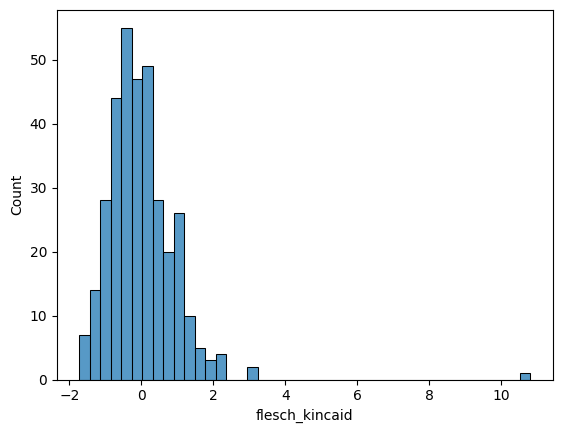

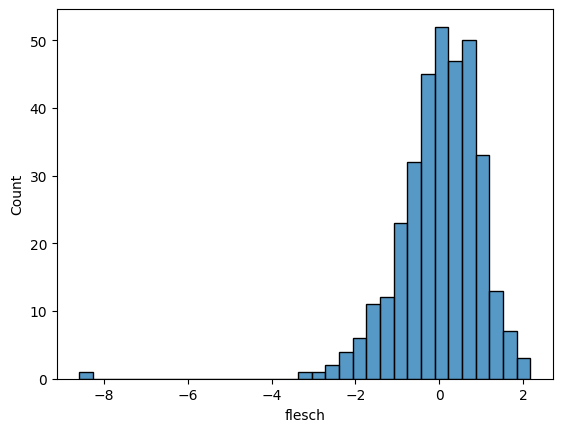

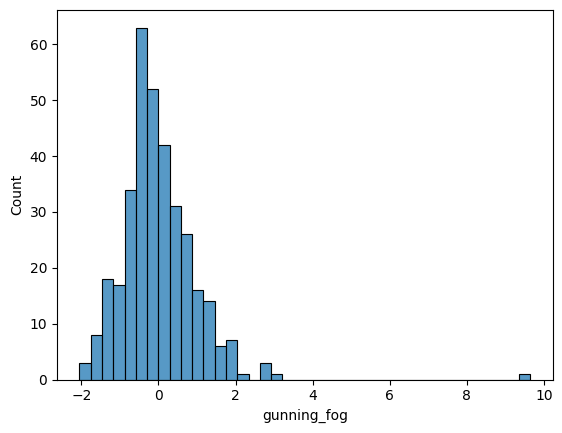

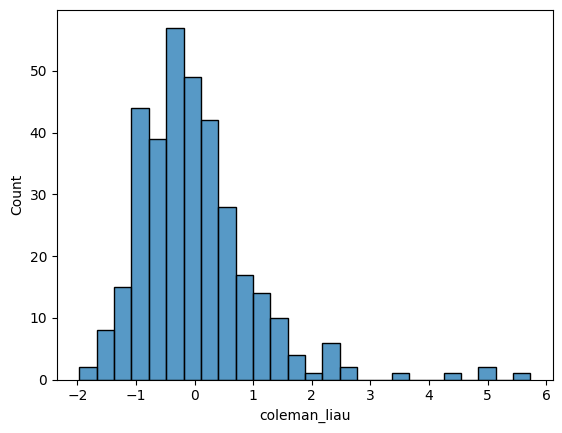

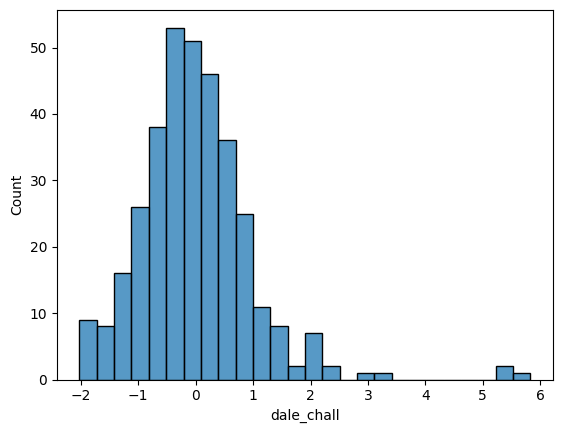

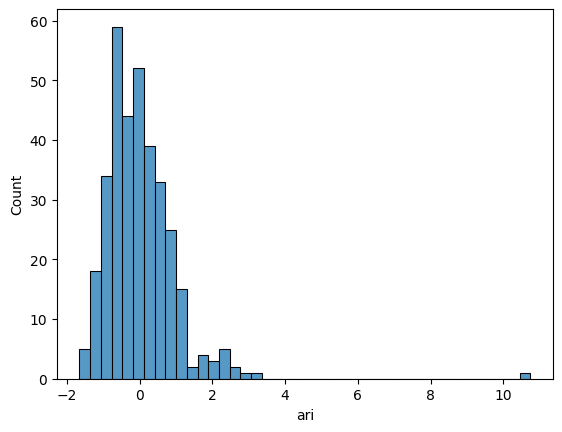

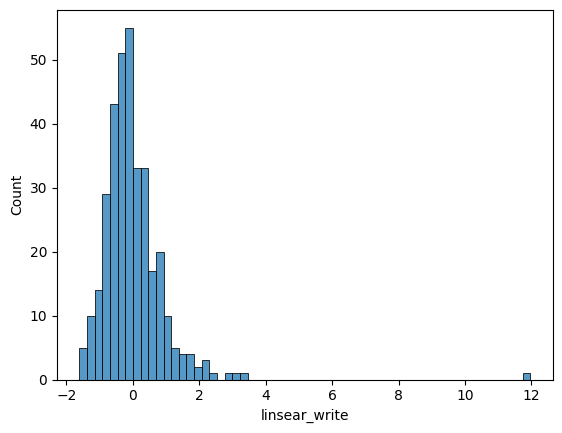

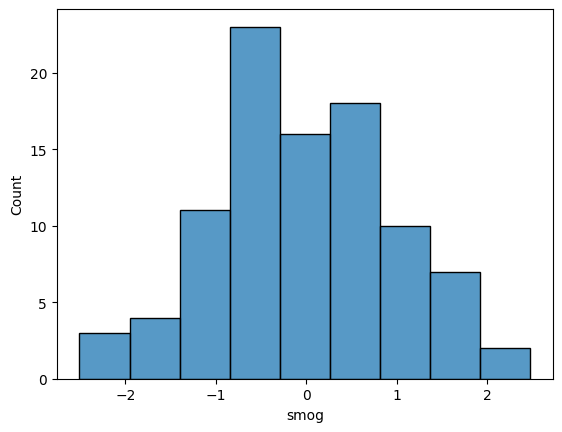

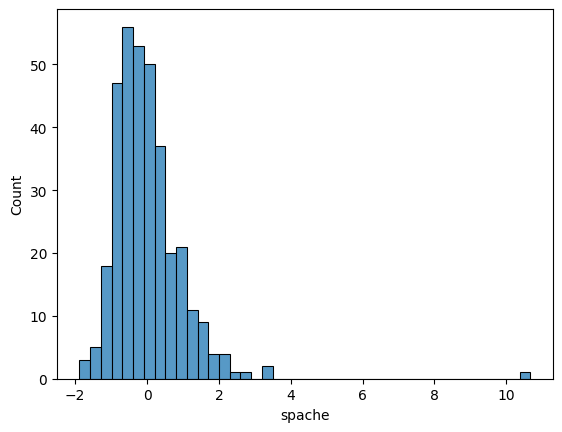

In [19]:
from matplotlib import pyplot as plt
for metric in scores:
    plt.figure()
    sns.histplot(df_grants[metric].dropna())

These metrics have a gaussian distribution thus we try to look at outliers to see which grants are the most difficult to read.

In [20]:
df_grants[scores].isna().sum()

flesch_kincaid     83
flesch             83
gunning_fog        83
coleman_liau       83
dale_chall         83
ari                83
linsear_write      83
smog              332
spache             83
dtype: int64

In [21]:
df_grants['flesch'].isna().sum()

83

In [22]:
print(f'Number of projects with no readability scores: {df_grants.flesch.isna().sum()} because of a small decription less then 100 characters')
print(f'Number of projects with no smog scores: {df_grants.smog.isna().sum()} because of a less then 30 sentences in the description')

Number of projects with no readability scores: 83 because of a small decription less then 100 characters
Number of projects with no smog scores: 332 because of a less then 30 sentences in the description


Because to many projects have less than 30 sentences, we will not take into account the number of sentences in the description

By extracting the grants where the readability score can not be computed there are already 96 grants to review.

In [23]:
df_grants.smog.isna().sum()

332

In [24]:
# add a colum smallDescription
df_grants['smallDescription'] = True
df_grants['smallDescription'] = df_grants[scores].isna().sum(axis=1) > 1

Lets investigate outliers that have readability values
6 sigma or more away from the mean is often considered to be outliers where sigma is the standard deviation.

Compute 6 sigma for each metric and extract grants with values outside 6 sigma
After trying only two grants where above 6 sigma for one metric, I decided to use 5 sigma instead

In [25]:
n_6_sigma = df_grants[(df_grants[scores].abs() > 6).sum(axis=1) > 0].shape[0]
n_5_sigma = df_grants[(df_grants[scores].abs() > 5).sum(axis=1) > 0].shape[0]
print(f'Number of projects with at least one score 6 sigma away from the mean: {n_6_sigma}')
print(f'Number of projects with at least one score 5 sigma away from the mean: {n_5_sigma}')


Number of projects with at least one score 6 sigma away from the mean: 1
Number of projects with at least one score 5 sigma away from the mean: 5


After reviewing these projects manually I decided to use another formula to detect outliers, because these grants were not written in english which explians the scores.

In [26]:
df_grants['lowReadability'] = (df_grants[scores].abs() > 2).sum(axis=1) > 3

In [27]:
scores_less_smog = ['flesch_kincaid', 'flesch', 'gunning_fog', 'coleman_liau', 'dale_chall', 'ari', 'linsear_write', 'spache']

In [28]:
df_grants_no_nan = df_grants.dropna(subset=scores_less_smog, axis=0)
detail_readability = df_grants_no_nan['lowReadability'].value_counts()
print(f'Number of projects with low readability: {detail_readability[True]}')
detail_readability

Number of projects with low readability: 10


lowReadability
False    333
True      10
Name: count, dtype: int64

## 2. Originality and AI detection

In [30]:
## Evaluate the cost of using OriginalityAI API
price_per_word = 0.01/100
n_words = len(df_grants_no_nan['metadata.application.project.description'].str.cat(sep=' ').split(' '))
print(f'Total API price ${int(n_words * price_per_word)}, the descriptions with less than 100 words are not included in the analysis')
print(f'Approximate number of credits ${int(n_words * price_per_word * 100)} needed')

Total API price $16, the descriptions with less than 100 words are not included in the analysis
Approximate number of credits $1660 needed


In [31]:
# load the API key from the .env file
load_dotenv()
ORIGINALITY_API_KEY = os.getenv('ORIGINALITY_API_KEY')

In [32]:
def originality_api(title, description):
    # API query the OriginalityAI API
    # return a tuple with the originality and ai scores
    url = 'https://api.originality.ai/api/v1/scan/ai'
    headers = {
        'Content-Type': 'application/json',
        'X-OAI-API-KEY': ORIGINALITY_API_KEY
    }
    data = {
      "title": title,
      "content": description
    }
    if len(description.split(' ')) < 100:
        originality, ai = np.nan, np.nan
    else:
        response = requests.post(url, headers=headers, json=data)
        if response.status_code == 200:
            if response.json().get('success'):
                score = response.json().get('score')
                originality, ai = score.get('original'), score.get('ai')
            else:
                print('Request response:', response.text)
                originality, ai = np.nan, np.nan
        else:
            print('Request failed with status code:', response.status_code)
            print('Reason:', response.reason)
            print('Request response:', response.text)
            originality, ai = np.nan, np.nan
    return originality, ai

There is a rate limit to the API so we will use a sleep function to avoid being blocked and we can't use the apply method.

In [33]:
df_grants['originality'] = np.nan
df_grants['ai'] = np.nan
cntr = 1
for index_grant in df_grants.index:
    if df_grants.loc[index_grant, 'smallDescription'] == True:
        print(f'Not processing small description index {index_grant}')
    else:
        cntr += 1
        if (cntr % 100 == 0):
            print(f'Waiting 1 minute, processed {cntr} api calls out of {len(df_grants)} grants')
            time.sleep(60) # wait 1 minute every 100 requests
        print(f'Processing grant index {index_grant}')
        title = df_grants.loc[index_grant, 'metadata.application.project.title']
        description = df_grants.loc[index_grant, 'metadata.application.project.description']

        df_grants.loc[index_grant, 'originality'], df_grants.loc[index_grant, 'ai'] = originality_api(title, description)

Not processing small description index 0
Processing grant index 118
Not processing small description index 116
Processing grant index 114
Processing grant index 113
Processing grant index 112
Processing grant index 111
Not processing small description index 110
Not processing small description index 109
Processing grant index 107
Processing grant index 106
Processing grant index 104
Not processing small description index 120
Processing grant index 103
Processing grant index 101
Not processing small description index 100
Not processing small description index 98
Processing grant index 97
Processing grant index 96
Processing grant index 94
Processing grant index 92
Processing grant index 91
Processing grant index 87
Processing grant index 81
Processing grant index 77
Processing grant index 102
Not processing small description index 76
Processing grant index 121
Processing grant index 123
Processing grant index 160
Not processing small description index 159
Processing grant index 155
Not 

In [34]:
df_grants.to_csv('../grants_with_originality.csv', index=False)

In [38]:
df_grants[['originality', 'ai']].describe()

originality          ai
count   339.000000  339.000000
mean      0.698774    0.301226
std       0.389746    0.389746
min       0.000000    0.000100
25%       0.475875    0.005250
50%       0.950300    0.049700
75%       0.994750    0.524125
max       0.999900    1.000000

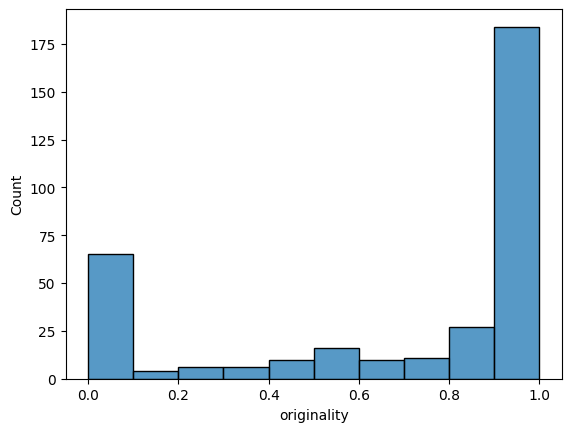

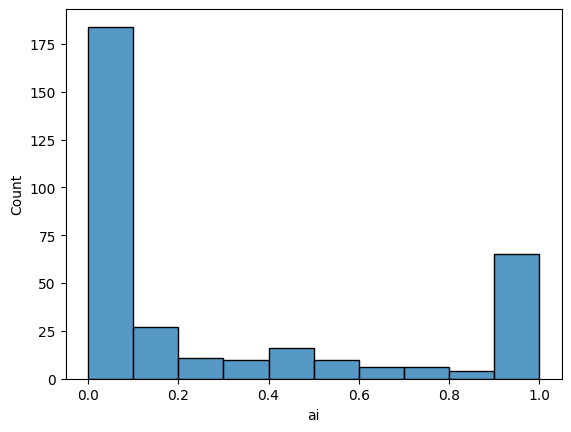

In [39]:
for metric in ['originality', 'ai']:
    plt.figure()
    sns.histplot(df_grants[metric].dropna())

In [69]:
low_originality = df_grants['originality'] == 0
print(f'Number of grants with low originality: {low_originality.sum()}')
high_ai = df_grants['ai'] == 1
print(f'Number of grants with high ai: {high_ai.sum()}')
print(f'Distinct originalit ai flagged projects: {np.logical_and(low_originality, np.logical_not(high_ai)).sum()}')
print(f'Number of flagged projects by originalityAI and lowReadability: {np.logical_and(df_grants.lowReadability, np.logical_and(low_originality, high_ai)).sum()}')

Number of grants with low originality: 19
Number of grants with high ai: 19
Distinct originalit ai flagged projects: 0
Number of flagged projects by originalityAI and lowReadability: 0


Low originality and high ai have exactly the same values when using oposite thresholds

Hopefully the ensemble is disjoint from the low readability ensemble

In [71]:
df_grants['lowOriginality'] = low_originality
df_grants['highAi'] = high_ai
df_grants['flagged'] = np.logical_or(np.logical_or(df_grants.lowReadability, df_grants.smallDescription), np.logical_or(low_originality, high_ai))

In [74]:
df_grants.flagged.value_counts()

flagged
False    314
True     112
Name: count, dtype: int64

In [78]:
print(f'Number of flagged projects: {df_grants.flagged.sum()} out of {len(df_grants)}, ratio {int(100*df_grants.flagged.sum()/len(df_grants))}%')

Number of flagged projects: 112 out of 426, ratio 26%


In [79]:
# export raw data
df_grants.to_csv('../grants_and_scores.csv', index=False)

In [84]:
small_colums = ['Round name', 'numRounds', 'metadata.application.project.title', 'status', 'metadata.application.project.website', 'metadata.application.project.projectTwitter', 'metadata.application.project.userGithub','metadata.application.project.projectGithub', 'metadata.application.recipient', 'originality', 'ai', 'smallDescription', 'lowReadability', 'lowOriginality', 'highAi', 'flagged']
rename_columns = ['Round name', 'numRounds', 'title', 'status', 'website', 'projectTwitter', 'userGithub', 'projectGithub', 'recipient', 'originality', 'ai', 'smallDescription', 'lowReadability', 'lowOriginality', 'highAi', 'flagged']

In [86]:
# export flagged projects with a limited set of columns
df_grants[df_grants.flagged][small_colums].set_axis(rename_columns, axis=1).to_csv('../flagged_grants.csv', index=False)

The analysis of the flagged projects is done manually in a google doc